# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 

# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 

# Part 2: Genres and communities and plotting 

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

In [64]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import ast
import json
import random
import statistics
from scipy.stats import pearsonr
from pathlib import Path
from typing import List, Dict, Optional
from collections import Counter

In [49]:
# Create Graph
G = nx.DiGraph()

files = os.listdir("Musicians")

for file in files:
    filepath = "Musicians/" + file
    with open(filepath, "r") as f:
        G.add_node(file.replace(".txt", ''), length_of_content = len(f.read().split()))

for file in files:
    filepath = "Musicians/" + file
    with open(filepath, "r") as f:
        filecontent = f.read()

        links = re.findall(r'\[\[([^|\]#]+)(?:#[^\]]*)?(?:\|([^\]]+))?\]\]', filecontent)

        for link, _ in links:
            link = link.replace("\\", "")
            link = link.replace('/', ' ')
            if link in list(G.nodes):
                G.add_edge(file.replace(".txt", ''), link.replace('/', ' '))

noConnections = [node for node in G.nodes if (G.out_degree(node) == 0 and G.in_degree(node) == 0)]

G.remove_nodes_from(noConnections)

largest_wcc = max(nx.weakly_connected_components(G), key=len)

GL = G.subgraph(largest_wcc).copy()

G_und = GL.to_undirected() 

In [41]:
def normalize_genre(genre_text: str) -> Optional[str]:
    """
    Cleans, lowercases, and normalizes a single genre string.
    """
    # Clean and lowercase
    g = genre_text.lower().strip()
    
    if not g:
        return None
    
    g = g.replace('-', ' ')
        
    # Normalize "rock'n'roll", "rock & roll", etc.
    # This rule is intentionally broad to catch variations.
    if 'rock' in g and ('roll' in g or '’n’' in g or '&' in g or "'n'" in g):
        return 'rock and roll'
    
    g = g.replace('&', 'and')
    
    if 'early' in g:
        g = g.replace(' (early)', '')
    
    if 'later' in g:
        g = g.replace(' (later)', '')
        
        
    # Add any other normalization rules here
    # For example:
    # if g == 'r&b':
    #     return 'r&b'
        
    return g

def extract_all_genres(directory_path: str) -> Dict[str, List[str]]:
    """
    Extracts genres for all artists from wikitext files in a directory.
    
    Args:
        directory_path: The path to the folder containing artist .txt files.

    Returns:
        A dictionary mapping artist names to a list of their genres.
    """
    artist_genres_map: Dict[str, List[str]] = {}
    p = Path(directory_path)
    
    if not p.is_dir():
        print(f"Error: Directory not found at {directory_path}")
        return {}

    # Define regex patterns
    # 1. Finds the main infobox
    infobox_re = re.compile(
        r"\{\{Infobox musical artist[\s\S]*?^\}\}", 
        re.MULTILINE | re.IGNORECASE
    )
    
    # 2. Finds the genre line within the infobox
    # This version stops when it sees the *next parameter* (e.g. "| label =")
    # or the end of the infobox, rather than just any line starting with "|".
    genre_line_re = re.compile(
        r"\| *genre *= *([\s\S]*?)\n *(?=\| *[a-z_ ]+ *=|^\}\})", 
        re.MULTILINE | re.IGNORECASE
    )
    
    # 3-7. Cleaning regex patterns
    link_display_re = re.compile(r"\[\[[^|\]]+\|([^\]]+)\]\]") # [[link|display]] -> display
    link_re = re.compile(r"\[\[([^\]]+)\]\]")                 # [[link]] -> link
    # NEW: Separator for adjacent links like ]] [[
    link_separator_re = re.compile(r"\]\](\s+)\[\[")
    
    list_template_re = re.compile(                           # {{hlist|a|b}} -> a|b
        r"\{\{(?:hlist|flatlist|unbulleted list)\s*\|([\s\S]*?)\}\}", 
        re.IGNORECASE
    )
    other_template_re = re.compile(r"\{\{[^}]+\}\}")         # {{template}} -> ""
    comment_re = re.compile(r"<!--[\s\S]*?-->")              # <!-- comment --> -> ""
    ref_re = re.compile(r"<ref[\s\S]*?(/>|</ref>)", re.IGNORECASE) # <ref ... /> -> ""
    # UPDATED: Add <br> variants to the separator list
    separator_re = re.compile(r"[|\n*]|<br */?>", re.IGNORECASE) # |, \n, *, <br> -> ,

    for file_path in p.glob('*.txt'):
        artist_name = file_path.stem
        wikitext = ""
        
        try:
            # Read the raw content
            raw_content = file_path.read_text(encoding='utf-8')
            
            # Try to parse as the 'ast' structure from your example
            try:
                data = ast.literal_eval(raw_content)
                page_id = list(data.keys())[0] # Get the first (only) page ID
                wikitext = data[page_id]['revisions'][0]['*']
            except (ValueError, SyntaxError, KeyError, IndexError, TypeError):
                # Fallback: assume the file is just raw wikitext
                wikitext = raw_content
                
            if not wikitext:
                print(f"No wikitext found for {artist_name}")
                continue

            # 1. Find infobox
            infobox_match = infobox_re.search(wikitext)
            if not infobox_match:
                # print(f"No infobox found for {artist_name}")
                continue
            
            infobox_text = infobox_match.group(0)

            # 2. Find genre line
            genre_match = genre_line_re.search(infobox_text)
            if not genre_match:
                # print(f"No genre line found for {artist_name}")
                continue
                
            content = genre_match.group(1)

            # --- Start cleaning the extracted genre content ---
            # The order of these operations is critical.
            
            # 0. Replace HTML entities like &nbsp;
            content = content.replace('&nbsp;', ' ')
            
            # 1. Remove HTML comments <!-- ... -->
            content = comment_re.sub("", content)
            # 2. Remove <ref> tags (which can contain nested templates)
            content = ref_re.sub("", content)
            
            # 3. NEW: Insert a separator (pipe) between adjacent links: ]] [[ -> ]] | [[
            # This handles cases like [[hard rock]] [[arena rock]]
            content = link_separator_re.sub(r"]]|\1[[", content)
            
            # 4. Simplify hlist/flatlist templates: {{hlist|a|b|c}} -> a|b|c
            content = list_template_re.sub(r"\1", content)
            # 5. Remove any other simple templates {{template}} -> ""
            content = other_template_re.sub("", content)
            # 6. Resolve links: [[link|display]] -> display
            content = link_display_re.sub(r"\1", content)
            # 7. Resolve links: [[link]] -> link
            content = link_re.sub(r"\1", content)
            # 8. Replace common separators (pipe, newline, asterisk, <br>) with commas
            content = separator_re.sub(",", content)
            
            # 9. Final cleanup: strip whitespace and any trailing template braces
            content = content.strip().rstrip('}')
            # --- Done cleaning ---

            # 10. Split by comma and process each potential genre
            potential_genres = content.split(',')
            genres_list = []
            
            for g_text in potential_genres:
                # Extra cleanup for trailing braces on individual items
                g_clean = g_text.strip().rstrip('}')
                
                # Skip any empty strings or leftover template/HTML bits
                # ADDED: Filter out template parameters (like 'italic=no' by checking for '=')
                # ADDED: Filter out very short items (like 'de' by checking length > 2)
                if (g_clean and
                    not g_clean.startswith('<') and
                    not g_clean.startswith('{') and
                    'class=' not in g_clean and
                    '=' not in g_clean and
                    len(g_clean) > 2):
                    
                    normalized = normalize_genre(g_clean)
                    if normalized:
                        genres_list.append(normalized)

            # 11. Add to map if we found any genres
            if genres_list:
                # Remove duplicates and sort
                unique_genres = list(set(genres_list))
                artist_genres_map[artist_name] = unique_genres

        except Exception as e:
            print(f"Error processing {artist_name} ({file_path.name}): {e}")
            
    return artist_genres_map


genre_dict = extract_all_genres("Musicians")

# Part 1: Analyze the network

**We want to present the some important facts about the network that results from the links between pages from rock musicians on wikipedia.**

**We start of with some basic facts on the network:**

**What is the number of nodes?**

**What is the number of edges?**

**What are the average, median, mode, minimum and maximum value of the in-degree and of the out-degree?**

In [16]:
in_degrees = dict(GL.in_degree())
out_degrees = dict(GL.out_degree())

nodes = list(GL.nodes())
x_out = [out_degrees[n] for n in nodes]
y_in  = [in_degrees[n] for n in nodes]

def compute_stats(values):
    return {
        "average": sum(values) / len(values),
        "median": statistics.median(values),
        "mode": statistics.mode(values),
        "min": min(values),
        "max": max(values) ,
    }

in_stats = compute_stats(y_in)
out_stats = compute_stats(x_out)

print(f"The network has {len(GL.nodes)} nodes and {len(GL.edges)} edges.")
print(f"The average degree of the nodes is {in_stats["average"]:.2f}.")
print(f"The median of the in-degrees is {in_stats["median"]}, the mode is {in_stats["mode"]}, the minimum is {in_stats["min"]}, and the maximum {in_stats["max"]}.")
print(f"If we compare this to the out-degrees, we notice that the out-degree distribution seems to be different, since the median is {out_stats["median"]}, the mode is {out_stats["mode"]}, the minimum is {out_stats["min"]}, and the maximum {out_stats["max"]}.")

The network has 484 nodes and 7329 edges.
The average degree of the nodes is 15.14.
The median of the in-degrees is 10.0, the mode is 4, the minimum is 0, and the maximum 119.
If we compare this to the out-degrees, we notice that the out-degree distribution seems to be different, since the median is 13.0, the mode is 12, the minimum is 0, and the maximum 74.


**To investigate this further, we will now plot the in- and out-degree distribution**

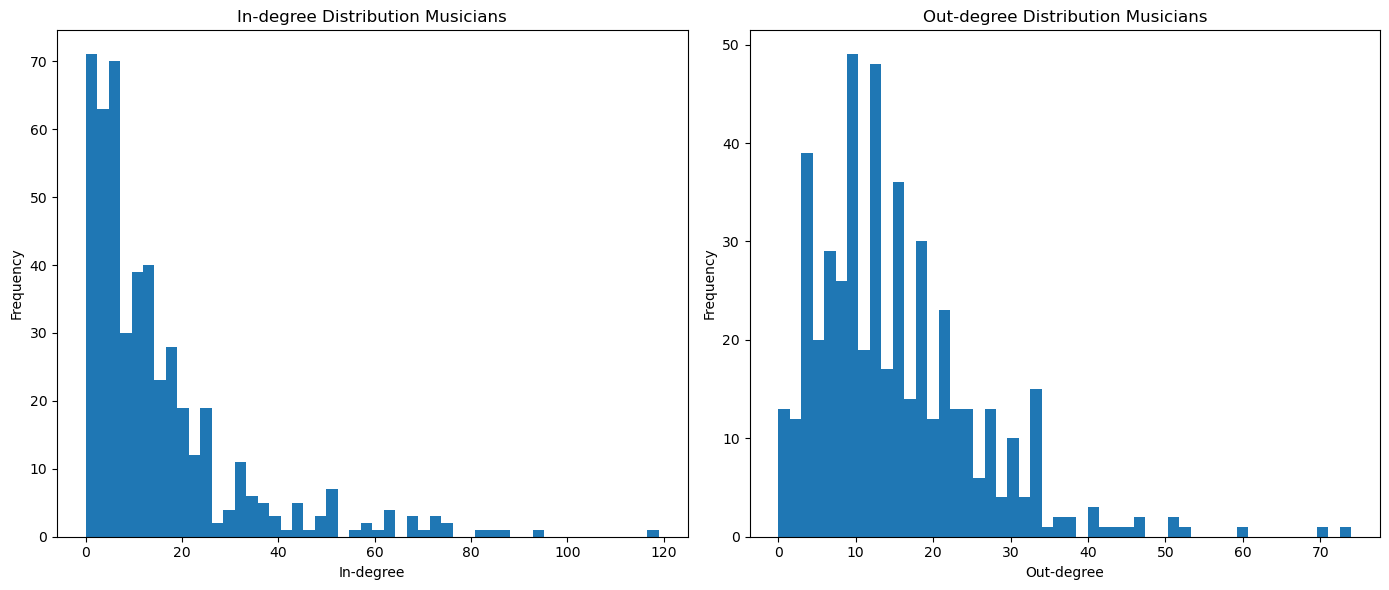

In [23]:
number_bins = 50

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist([x for x in y_in], bins=number_bins)
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.title("In-degree Distribution Musicians")

plt.subplot(1,2,2)
plt.hist([x for x in x_out], bins=number_bins)
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.title("Out-degree Distribution Musicians")
plt.tight_layout()
plt.show()

Most musicians have an in-degree of 0 or a very small one, and a few musicians have a very high in-degree. The out-degree follows more of a normal distribution. Our theory for why this is the case is that many musicians draw inspiration from a very small group of highly influential musicians. 

**To investige this further we will now look into the degree distributions of the individual musicians in more detail.**

**First we will create a scatter plot, where each point is a musician, and the axes show in- versus out-degree**

62


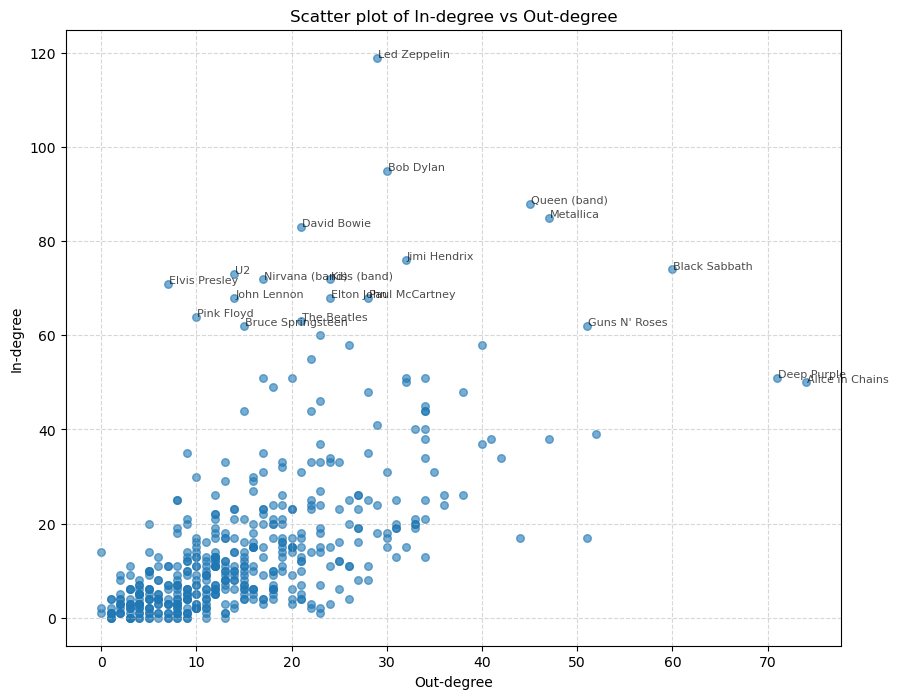

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(x_out, y_in, alpha=0.6, s=30)

print(y_in[nodes.index("Guns N' Roses")])

for i, node in enumerate(nodes):
    if x_out[i] > 60 or y_in[i] > 60:
        plt.text(x_out[i]+0.1, y_in[i]+0.1, str(node), fontsize=8, alpha=0.7)

plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("Scatter plot of In-degree vs Out-degree")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

This scatter plot shows the in- versus out-degree for each musician. To avoid too much overlapping of names, only the nodes that have an in- or out-degree over 60 have a label.

We notice that there is indeed some few musicians with a very high in-degree, who are all well known, which supports our theory from above.

We also notice that most musicians have an in- and out-degree both less than 20. However, we can also see not two much due to the many nodes in that area. 

**So we will create a heatmap in the next step, that zooms in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot.**

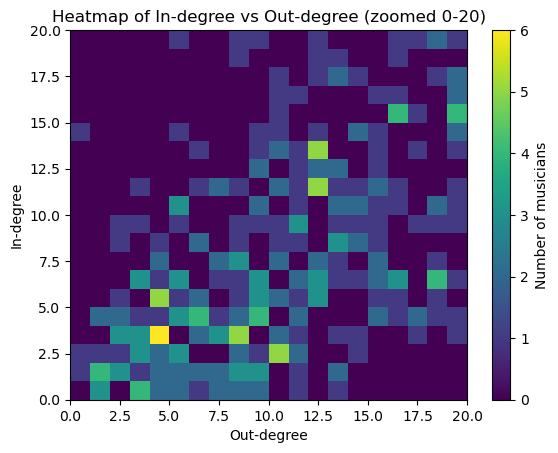

In [27]:
h = plt.hist2d(
    x_out,
    y_in,
    bins=[20, 20],
    range=[[0, 20], [0, 20]],
    cmap='viridis'
)

plt.colorbar(label="Number of musicians")
plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("Heatmap of In-degree vs Out-degree (zoomed 0-20)")

plt.show()

In this heatmap we can see again support for our theory. We see that the majority of musicians has lower in-degree then out-degree.

**To further support our theory, we will now calculate the pearson correlation between the length of the wikipedia articals and the in-degree, since longer wikipedia articiles could also be a sign of famous characters**

In [36]:
lengths = [G.nodes[n].get('length_of_content', 0) for n in G.nodes()]
in_degrees_pearson = [G.in_degree(n) for n in G.nodes()]

pearson_in  = pearsonr(lengths, in_degrees_pearson)
print(f"The pearson correlation is {pearson_in.correlation:.4f}, which is a very high correlation, which again supports our theory")

The pearson correlation is 0.7022, which is a very high correlation, which again supports our theory


# Part 2: Genres and communities and plotting 

**We extracted the genre of all musicians with help of the infoboxes of Wikipedia. We start investigating the genres my calculating the number of nodes for which we could find a genre, the average number of genres per node, the total number of distinct genres, and a histogram showing artist counts for the top 15 genres.**


--- Genre Statistics ---
Nodes with genres found: 425
Average genres per node: 3.75
Total distinct genres:   189


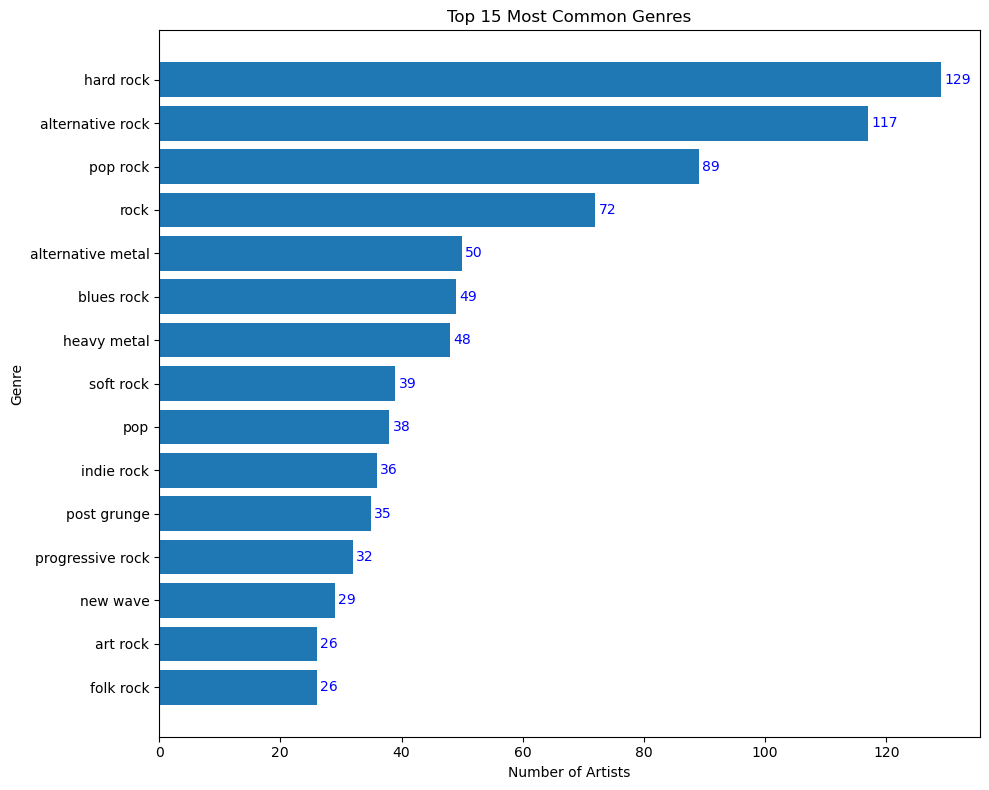

In [52]:
# As suggested in the part 2 of week 5, we used an LLM to extract the genres and report on the statistics, with extensive testing and revisions to ensure everything works as expected

def report_genre_stats(artist_genres_map: Dict[str, List[str]]):
    """
    Calculates and prints genre statistics, then displays a bar chart.
    """
    print("\n--- Genre Statistics ---")
    
    # 1. Number of nodes with genres
    num_nodes_with_genres = len(artist_genres_map)
    if num_nodes_with_genres == 0:
        print("No genres found for any artists.")
        return
        
    print(f"Nodes with genres found: {num_nodes_with_genres}")

    # 2. Average number of genres per node
    total_genres_assigned = sum(len(genres) for genres in artist_genres_map.values())
    avg_genres = total_genres_assigned / num_nodes_with_genres
    print(f"Average genres per node: {avg_genres:.2f}")

    # 3. Total number of distinct genres
    all_genres_list = [genre for genres in artist_genres_map.values() for genre in genres]
    distinct_genres = set(all_genres_list)
    num_distinct_genres = len(distinct_genres)
    print(f"Total distinct genres:   {num_distinct_genres}")

    # 4. Histogram for top 15 genres
    
    genre_counts = Counter(all_genres_list)
    top_15_genres = genre_counts.most_common(15)
    
    if not top_15_genres:
        print("No genre data to display.")
        return

    # Unzip the data for plotting
    # We reverse the lists [::-1] so the highest bar is at the top
    genres = [genre for genre, count in top_15_genres][::-1]
    counts = [count for genre, count in top_15_genres][::-1]

    # Create horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(genres, counts)
    plt.xlabel('Number of Artists')
    plt.ylabel('Genre')
    plt.title('Top 15 Most Common Genres')
    
    # Add counts to the end of the bars
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(v), color='blue', va='center')

    plt.tight_layout()  # Adjust plot to prevent label overlap
    plt.show()          # Display the plot

report_genre_stats(genre_dict)

We find that almost all of the nodes have at least one genre, which allows us to maybe use it as a good measurement for detecting communities in the network. However, each artist has an average of 3.75 genres, so the question is which one to choose.

In [135]:
def calculate_genre_modularity(artist_genres_map: Dict[str, List[str]], which_mode):    
    """
    Calculates the modularity of a network based on genre communities.
    
    The partition is created by assigning each node to the *first* genre
    in its list.
    
    Args:
        G_und: The full undirected NetworkX graph.
        artist_genres_map: The dictionary mapping artists to genre lists.
    """
    
    print("Starting modularity calculation...")
    
    # 1. Work from the undirected version, keeping only nodes with genre info
    nodes_with_genres = set(artist_genres_map.keys())
    nodes_in_graph = set(G_und.nodes())
    
    valid_nodes = nodes_with_genres.intersection(nodes_in_graph)
    
    if not valid_nodes:
        print("Error: No nodes from your graph were found in the genre map.")
        return

    # Create the filtered subgraph. .copy() is important!
    G_filtered = G_und.subgraph(valid_nodes).copy()
    print(f"Filtered graph created: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges.")
    
    if G_filtered.number_of_edges() == 0:
        print("Filtered graph has no edges. Modularity is 0.")
        return 0.0

    # 2. Create the partition: {node: first_genre}
    partition = {}
    for node in G_filtered.nodes():
        # Check that the node (which we know is in the map) has genres
        if artist_genres_map.get(node): # Use .get() for safety
            if which_mode == 0:
                first_genre = artist_genres_map[node][0]
            elif which_mode == 1:
                temp = 0
                if len(artist_genres_map[node]) > 1:
                    temp = 1
                first_genre = artist_genres_map[node][temp]
            else:
                first_genre = artist_genres_map[node][random.randint(0, len(artist_genres_map[node])-1)]
            partition[node] = first_genre
    
    # We must remove nodes from the filtered graph that ended up with no
    # genre (e.g., if their list was empty, which shouldn't happen with
    # the current extract_all_genres, but it's good practice)
    nodes_in_partition = set(partition.keys())
    if not nodes_in_partition:
        print("Error: No nodes could be assigned to a partition.")
        return 0.0
        
    G_partitioned = G_filtered.subgraph(nodes_in_partition).copy()
    
    L = G_partitioned.number_of_edges()
    
    if L == 0:
        print("Partitioned graph has no edges. Modularity is 0.")
        return 0.0

    two_L = 2.0 * L
    print(f"Partitioned graph created: {G_partitioned.number_of_nodes()} nodes, {L} edges.")
    
    # 3. Calculate Modularity using Equation 9.12
    # M = Σ_c [ (L_c / L) - (k_c / 2L)^2 ]
    
    print(f"Calculating modularity from formula (Eq 9.12)...")

    # 3a. Get all unique communities and their nodes
    communities = {} # {community_name: [node1, node2, ...]}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)
    
    print(f"Found {len(communities)} unique communities (genres).")
    
    # 3b. Get L (total edges) and 2L
    # L and two_L are already defined above
    degrees = dict(G_partitioned.degree())
    
    # 3c. Sum terms for each community
    modularity_sum = 0.0
    for comm_name, nodes_in_comm in communities.items():
        
        # Calculate L_c: number of edges *within* the community
        # Create a subgraph view of just the nodes in this community
        comm_subgraph = G_partitioned.subgraph(nodes_in_comm)
        L_c = comm_subgraph.number_of_edges()
        
        # Calculate k_c: sum of degrees of all nodes in the community
        # (These are degrees from the *full* partitioned graph)
        k_c = 0.0
        for node in nodes_in_comm:
            k_c += degrees[node]
            
        # Calculate the term for this community
        term_1 = L_c / L
        term_2 = (k_c / two_L)**2
        
        modularity_sum += (term_1 - term_2)
        
    M = modularity_sum
        
    return M

calculate_genre_modularity(genre_dict, 3)

Starting modularity calculation...
Filtered graph created: 425 nodes, 4536 edges.
Partitioned graph created: 425 nodes, 4536 edges.
Calculating modularity from formula (Eq 9.12)...
Found 111 unique communities (genres).


0.03794708469807678